Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.cluster import KMeans
from mlxtend.frequent_patterns import apriori, association_rules

Getting the data

In [4]:
df=pd.read_excel('Online Retail.xlsx')

#Data Exploration

In [5]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [7]:
df.shape

(541909, 8)

In [8]:
print(df.dtypes)

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object


In [9]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


The above cell shows that the 'Quantity' and 'UnitPrice' columns have negative values

In [10]:
def descr(df):
  no_rows=df.shape[0]
  types=df.dtypes
  counts=df.apply(lambda x: x.count())
  uniques=df.apply(lambda x: x.unique())
  nulls=df.apply(lambda x: x.isnull().sum())
  distincts=df.apply(lambda x: x.unique().shape[0])
  nan_percent=(df.isnull().sum()/no_rows)*100
  skewness=df.skew()
  kurtosis=df.kurt()

  cols={'dtypes':types, 'counts':counts, 'distincts':distincts, 'nulls':nulls,  
        'missing_percent':nan_percent, 'uniques':uniques, 'skewness':skewness, 'kurtosis':kurtosis}
  table=pd.DataFrame(data=cols)
  return table

details = descr(df)
display(details.sort_values(by='missing_percent', ascending=False))

C:\Users\gv7lo\AppData\Local\Temp/ipykernel_17060/480016412.py:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  skewness=df.skew()
C:\Users\gv7lo\AppData\Local\Temp/ipykernel_17060/480016412.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  kurtosis=df.kurt()


,dtypes,counts,distincts,nulls,missing_percent,uniques,skewness,kurtosis
CustomerID,float64,406829,4373,135080,24.926694,"[17850.0, 13047.0, 12583.0, 13748.0, 15100.0, ...",0.029835,-1.179982
Description,object,540455,4224,1454,0.268311,"[WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...",NaN,NaN
Country,object,541909,38,0,0.000000,"[United Kingdom, France, Australia, Netherland...",NaN,NaN
InvoiceDate,datetime64[ns],541909,23260,0,0.000000,"[2010-12-01T08:26:00.000000000, 2010-12-01T08:...",NaN,NaN
InvoiceNo,object,541909,25900,0,0.000000,"[536365, 536366, 536367, 536368, 536369, 53637...",NaN,NaN
Quantity,int64,541909,722,0,0.000000,"[6, 8, 2, 32, 3, 4, 24, 12, 48, 18, 20, 36, 80...",-0.264076,119769.160031
StockCode,object,541909,4070,0,0.000000,"[85123A, 71053, 84406B, 84029G, 84029E, 22752,...",NaN,NaN
UnitPrice,float64,541909,1630,0,0.000000,"[2.55, 3.39, 2.75, 7.65, 4.25, 1.85, 1.69, 2.1...",186.506972,59005.719097


From here we can see that 'CustomerID' and 'Description' columns have NaN values.

#**Data Cleaning**

Finding out where all the negative and values are present

In [11]:
print("Number of rows where negative values are present : ", 
      df[(df['Quantity']<0) | (df['UnitPrice']<0)].shape[0])

print("\nAre negative values in both Quantity and UnitPrice present in same row : ", end="")
if df[(df['Quantity']<0) & (df['UnitPrice']<0)].shape[0]==0:
  print("No")
else:
  print("Yes")

print("\nAre negative or 0 values in both Quantity and UnitPrice present in same row : ", end="")
if df[(df['Quantity']<=0) & (df['UnitPrice']<=0)].shape[0]==0:
  print("No")
else:
  print("Yes")

print("What is the customer ID of such rows :",
      df.loc[(df.Quantity<=0) & (df.UnitPrice<=0), ['CustomerID']].CustomerID.unique())

Number of rows where negative values are present :  10626

Are negative values in both Quantity and UnitPrice present in same row : No

Are negative or 0 values in both Quantity and UnitPrice present in same row : Yes
What is the customer ID of such rows : [nan]


In [12]:
print("Invoice Numbers of rows with quantity having negative values : ") 
print(df.loc[(df.Quantity<0) & ~(df.CustomerID.isnull()), 'InvoiceNo'])
print("\nAll the Invoice Numbers start with : ", df.loc[(df.Quantity<0) & ~(df.CustomerID.isnull()), 'InvoiceNo'].apply(lambda x: x[0]).unique())

Invoice Numbers of rows with quantity having negative values : 
141       C536379
154       C536383
235       C536391
236       C536391
237       C536391
           ...   
540449    C581490
541541    C581499
541715    C581568
541716    C581569
541717    C581569
Name: InvoiceNo, Length: 8905, dtype: object

All the Invoice Numbers start with :  ['C']


In [13]:
print("Invoice Numbers of rows with UnitPrice having negative values : ") 
display(df[(df.UnitPrice<0) & (df.CustomerID.isnull())])
print("\nAll the Invoice Numbers start with : ", df.loc[(df.UnitPrice<0) & (df.CustomerID.isnull()), 'InvoiceNo'].apply(lambda x: x[0]).unique())

print("\nInvoice Numbers of rows with UnitPrice having 0 values : ") 
display(df[(df.UnitPrice==0) & ~(df.CustomerID.isnull())].head(10))
print("Total number of rows : ", df[(df.UnitPrice==0) & ~(df.CustomerID.isnull())].shape[0])
#print("\nAll the Invoice Numbers start with : ", df.loc[(df.UnitPrice==0) & ~(df.CustomerID.isnull()), 'InvoiceNo'].apply(lambda x: x[0]).unique())

Invoice Numbers of rows with UnitPrice having negative values : 


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom



All the Invoice Numbers start with :  ['A']

Invoice Numbers of rows with UnitPrice having 0 values : 


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-05 14:02:00,0.0,12647.0,Germany
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,2010-12-16 14:36:00,0.0,16560.0,United Kingdom
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,2010-12-21 13:45:00,0.0,14911.0,EIRE
47068,540372,22090,PAPER BUNTING RETROSPOT,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom
47070,540372,22553,PLASTERS IN TIN SKULLS,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom
56674,541109,22168,ORGANISER WOOD ANTIQUE WHITE,1,2011-01-13 15:10:00,0.0,15107.0,United Kingdom
86789,543599,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,16,2011-02-10 13:08:00,0.0,17560.0,United Kingdom
130188,547417,22062,CERAMIC BOWL WITH LOVE HEART DESIGN,36,2011-03-23 10:25:00,0.0,13239.0,United Kingdom
139453,548318,22055,MINI CAKE STAND HANGING STRAWBERY,5,2011-03-30 12:45:00,0.0,13113.0,United Kingdom
145208,548871,22162,HEART GARLAND RUSTIC PADDED,2,2011-04-04 14:42:00,0.0,14410.0,United Kingdom


Total number of rows :  40


Dropping the rows having negative and null values based on what we found above

In [14]:
df=df[~(df.CustomerID.isnull())]
df = df[~(df.Quantity<0)]
df = df[df.UnitPrice>0]
df.reset_index()
details = descr(df)
display(details.sort_values(by='distincts', ascending=False))
print(df.shape)

C:\Users\gv7lo\AppData\Local\Temp/ipykernel_17060/480016412.py:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  skewness=df.skew()
C:\Users\gv7lo\AppData\Local\Temp/ipykernel_17060/480016412.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  kurtosis=df.kurt()


,dtypes,counts,distincts,nulls,missing_percent,uniques,skewness,kurtosis
InvoiceNo,object,397884,18532,0,0.0,"[536365, 536366, 536367, 536368, 536369, 53637...",-0.178524,-1.200748
InvoiceDate,datetime64[ns],397884,17282,0,0.0,"[2010-12-01T08:26:00.000000000, 2010-12-01T08:...",NaN,NaN
CustomerID,float64,397884,4338,0,0.0,"[17850.0, 13047.0, 12583.0, 13748.0, 15100.0, ...",0.025729,-1.180822
Description,object,397884,3877,0,0.0,"[WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...",NaN,NaN
StockCode,object,397884,3665,0,0.0,"[85123A, 71053, 84406B, 84029G, 84029E, 22752,...",NaN,NaN
UnitPrice,float64,397884,440,0,0.0,"[2.55, 3.39, 2.75, 7.65, 4.25, 1.85, 1.69, 2.1...",204.032727,58140.396673
Quantity,int64,397884,301,0,0.0,"[6, 8, 2, 32, 3, 4, 24, 12, 48, 18, 20, 36, 80...",409.892972,178186.243253
Country,object,397884,37,0,0.0,"[United Kingdom, France, Australia, Netherland...",NaN,NaN


(397884, 8)


Here, we have removed all null and negative values from dataset

In [15]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,397884.000000,397884.000000,397884.000000
mean,12.988238,3.116488,15294.423453
std,179.331775,22.097877,1713.141560
min,1.000000,0.001000,12346.000000
25%,2.000000,1.250000,13969.000000
50%,6.000000,1.950000,15159.000000
75%,12.000000,3.750000,16795.000000
max,80995.000000,8142.750000,18287.000000


In [16]:
dfv=df.copy()                               #making a copy of DataFrame 

Assigning numerical values to all the elements in StockCode

In [17]:
x=dfv['StockCode'].value_counts()
item_type_mapping={}
item_list=x.index
for i in range(0,len(item_list)):
    item_type_mapping[item_list[i]]=i

dfv['StockCode']=dfv['StockCode'].map(lambda x:item_type_mapping[x]) 



In [18]:
dfv['amount'] = dfv.Quantity*dfv.UnitPrice
dfv['amount']

0         15.30
1         20.34
2         22.00
3         20.34
4         20.34
          ...  
541904    10.20
541905    12.60
541906    16.60
541907    16.60
541908    14.85
Name: amount, Length: 397884, dtype: float64

#Data Visualization

<AxesSubplot:>

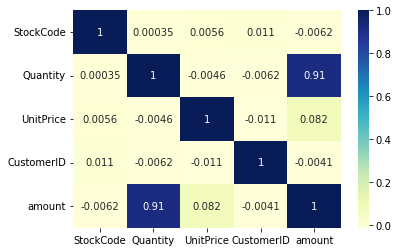

In [19]:
sns.heatmap(dfv.corr(), cmap="YlGnBu", annot=True)

In [20]:
# sns.pairplot(dfv)

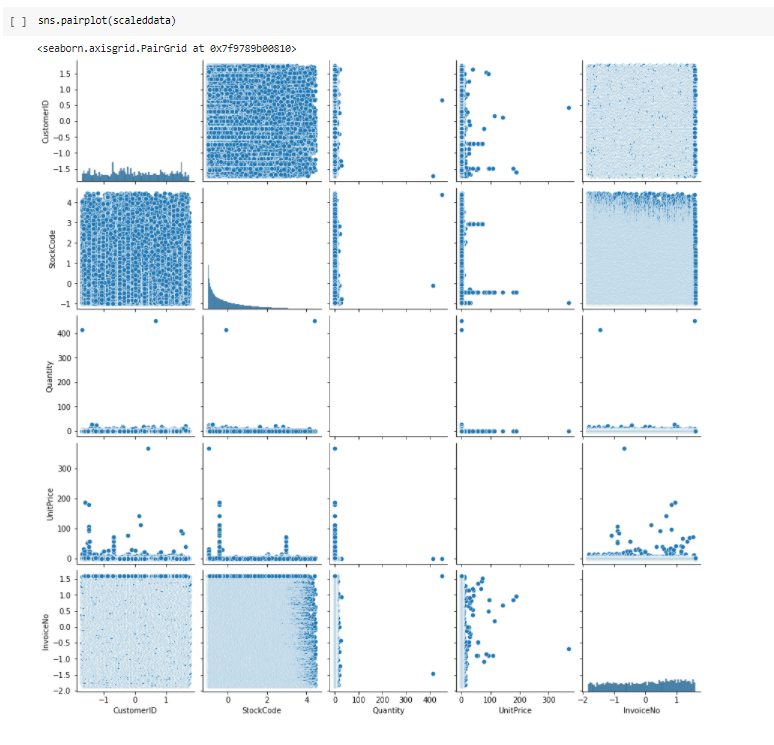

As we can see there are a few outliers in the dataset. These outliers affect the model, so we must remove them to get best results.

In [21]:
dfv = dfv[~(dfv.Quantity>dfv.Quantity.quantile(0.95))]
dfv = dfv[~(dfv.UnitPrice>dfv.UnitPrice.quantile(0.95))]

In [22]:
# pd.plotting.scatter_matrix(dfv, alpha=0.5, figsize=(8,8))

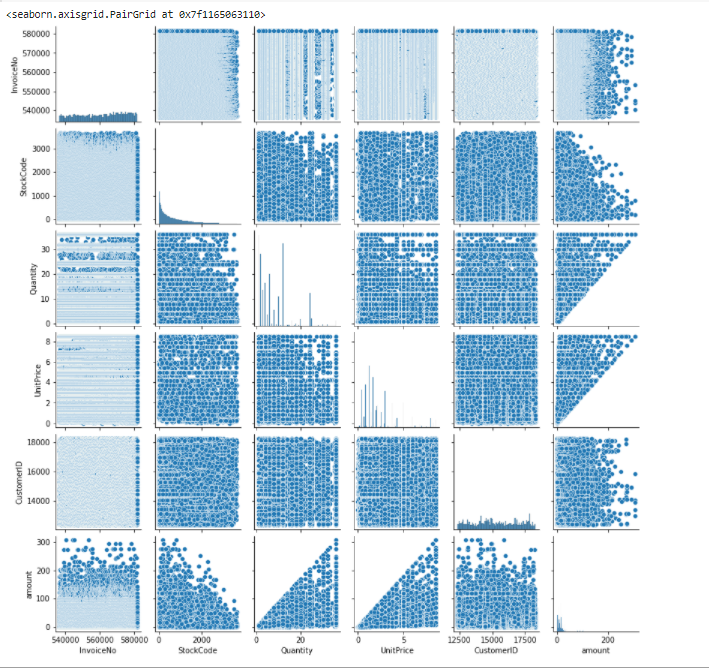

In [23]:
dfv.describe()

,StockCode,Quantity,UnitPrice,CustomerID,amount
count,361147.000000,361147.000000,361147.000000,361147.000000,361147.000000
mean,657.237086,7.689010,2.462422,15317.936577,13.781492
std,667.823873,7.491245,1.974761,1709.619269,15.557298
min,0.000000,1.000000,0.001000,12347.000000,0.001000
25%,135.000000,2.000000,1.250000,13988.000000,4.160000
50%,429.000000,5.000000,1.690000,15220.000000,10.200000
75%,978.000000,12.000000,2.950000,16814.000000,17.400000
max,3663.000000,36.000000,8.500000,18287.000000,306.000000


<AxesSubplot:xlabel='Country'>

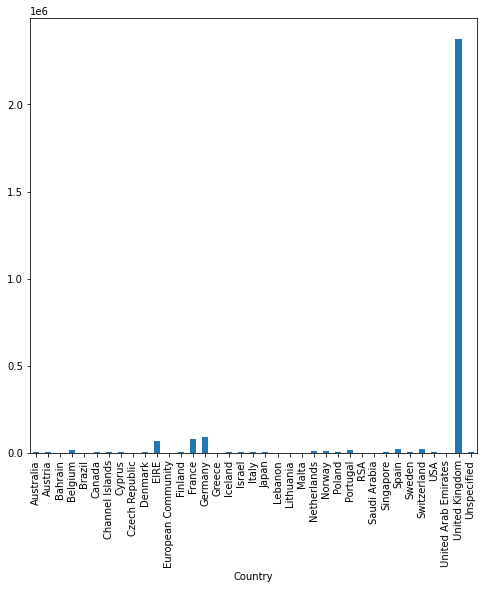

In [24]:
dfv.groupby('Country')['Quantity'].sum().plot(kind = 'bar', figsize=(8,8))

This shows that compared to UK all other countries have very less sales

<AxesSubplot:>

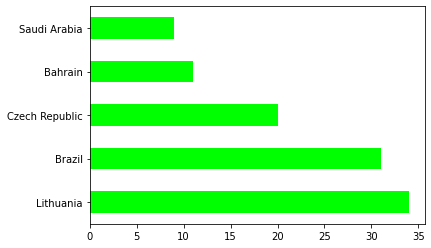

In [25]:
dfv.Country.value_counts()[-5:].plot(kind='barh',colormap='brg_r')

These are the countries with least sales

In [26]:
dfv['year'] = dfv['InvoiceDate'].dt.year
dfv['month'] = dfv['InvoiceDate'].dt.month
dfv['hour'] = dfv['InvoiceDate'].dt.hour
dfv['weekday'] = dfv['InvoiceDate'].dt.day_name()

<AxesSubplot:xlabel='hour'>

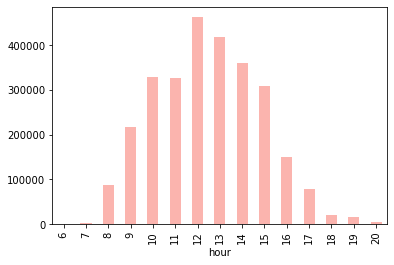

In [27]:
dfv.groupby('hour')['Quantity'].sum().plot(kind = 'bar', colormap = 'Pastel1')

This plot shows that afternoons are the busiest times

<AxesSubplot:xlabel='month'>

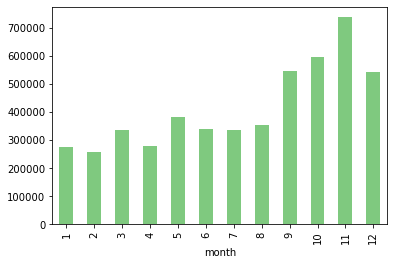

In [28]:
dfv.groupby('month')['amount'].sum().plot(kind='bar', colormap = 'Accent')

This shows that maximum sales have taken place in the last months

<AxesSubplot:xlabel='year'>

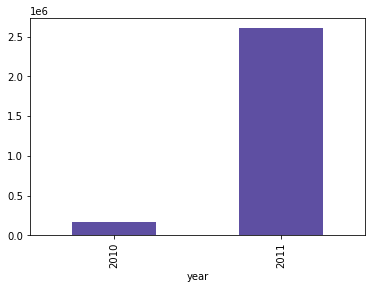

In [29]:
dfv.groupby('year')['Quantity'].sum().plot(kind='bar',colormap = 'Spectral_r')

In [30]:
dfv.InvoiceDate.sort_values()

0        2010-12-01 08:26:00
1        2010-12-01 08:26:00
2        2010-12-01 08:26:00
3        2010-12-01 08:26:00
4        2010-12-01 08:26:00
                 ...        
541896   2011-12-09 12:50:00
541895   2011-12-09 12:50:00
541907   2011-12-09 12:50:00
541900   2011-12-09 12:50:00
541908   2011-12-09 12:50:00
Name: InvoiceDate, Length: 361147, dtype: datetime64[ns]

The huge difference between the years is because the dataset starts from december of 2010 and ends in december 2011

<AxesSubplot:xlabel='weekday'>

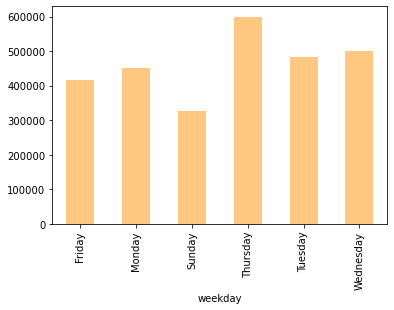

In [31]:
dfv.groupby('weekday')['Quantity'].sum().plot(kind='bar',colormap = 'copper_r')

Here we can see that no sales happen on Saturday, so the shop must be closed that day and the busiest day is Thursday

<AxesSubplot:title={'center':'Top 30 Products'}>

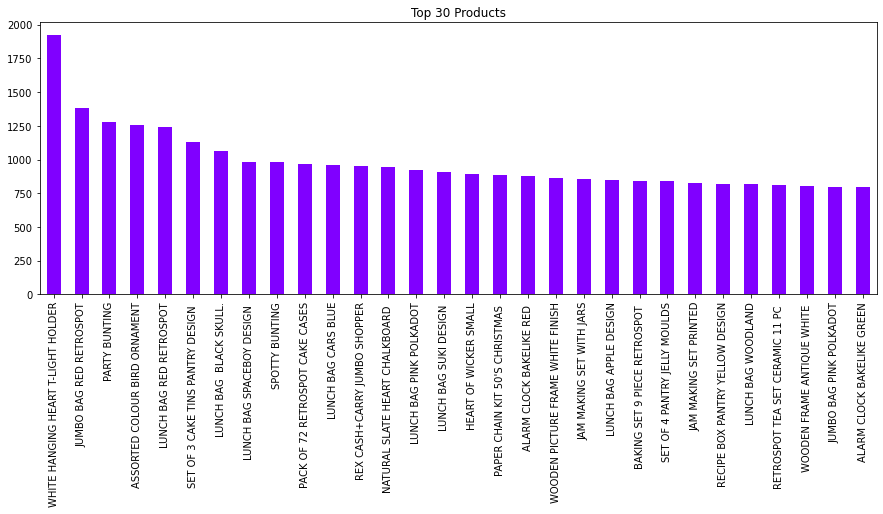

In [32]:
dfv.Description.value_counts().sort_values(ascending=False)[:30].plot(kind='bar', colormap='rainbow', figsize=(15,5), title="Top 30 Products")

<AxesSubplot:title={'center':'Last 30 Products'}>

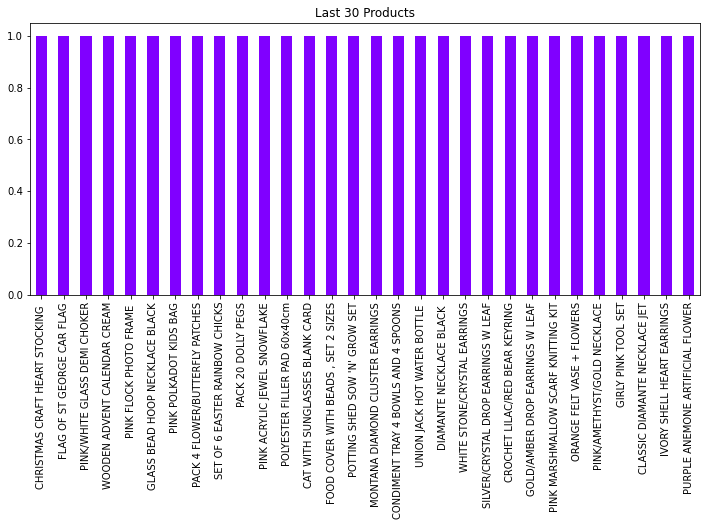

In [33]:
dfv.Description.value_counts().sort_values(ascending=False)[-30:].plot(kind='bar', colormap='rainbow', figsize=(12,5), title="Last 30 Products")

<AxesSubplot:title={'center':'Top 20 Customers'}>

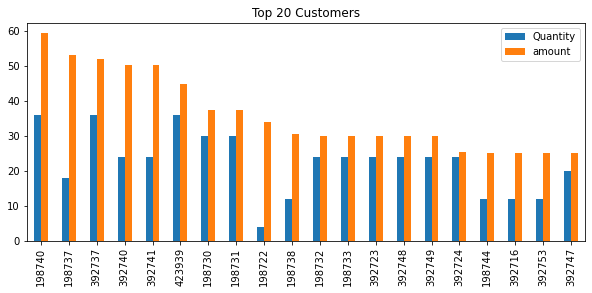

In [34]:
dfv.sort_values(['CustomerID','amount'], ascending=False).drop(['InvoiceDate','InvoiceNo','StockCode','CustomerID','year','month','hour', 'UnitPrice'], axis=1)[:20].plot(kind='bar', figsize=(10,4), title='Top 20 Customers')

<AxesSubplot:title={'center':'Last 20 Customers'}>

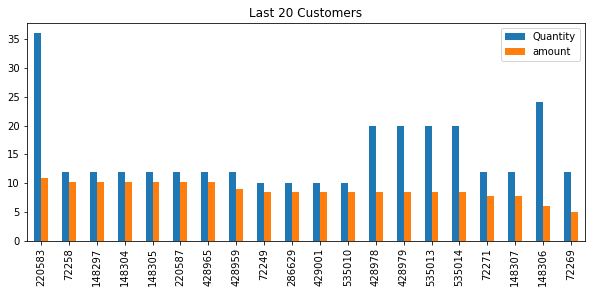

In [35]:
dfv.sort_values(['CustomerID','amount'], ascending=False).drop(['InvoiceDate','InvoiceNo','StockCode','CustomerID','year','month','hour', 'UnitPrice'], axis=1)[-20:].plot(kind='bar', figsize=(10,4), title='Last 20 Customers')

#**RFM Model**

**RFM Model for Customer Value:**
Due to lack of other data columns, we have used a RFM method, *Recency, Frequency and Monetary Value*. It uses customer behaviour for finding our customer segments. The RFM model will take the transactions of a customer and calculate three important informational attributes about each customer:



**Recency**: Number of days since last purchase


In [36]:
refrence_date = dfv.InvoiceDate.max() + datetime.timedelta(days = 1)
print('Reference Date:', refrence_date)
dfv['days_since_last_purchase'] = (refrence_date - dfv.InvoiceDate).astype('timedelta64[D]')

customer_history_df =  dfv[['CustomerID', 'days_since_last_purchase']].groupby("CustomerID").min().reset_index()
customer_history_df.rename(columns={'days_since_last_purchase':'recency'}, inplace=True)
customer_history_df.describe().transpose()
customer_history_df.shape


Reference Date: 2011-12-10 12:50:00


(4214, 2)

**Frequency**: Total number of transactions

In [37]:
customer_freq = (dfv[['CustomerID', 'InvoiceNo']].groupby("CustomerID").count().reset_index())
customer_freq.rename(columns={'InvoiceNo':'frequency'},inplace=True)
customer_history_df = customer_history_df.merge(customer_freq)
customer_history_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CustomerID,4214.0,15288.899383,1718.660576,12347.0,13809.25,15278.0,16767.75,18287.0
recency,4214.0,92.344091,99.958514,1.0,18.00,51.0,143.00,374.0
frequency,4214.0,85.701709,213.319912,1.0,16.00,39.0,94.00,7579.0



**Monetary value**: The dollar (or pounds in our case) value of all the transactions that the customer made at the establishment

In [38]:
customer_monetary_val = dfv[['CustomerID', 'amount']].groupby("CustomerID").sum().reset_index()
customer_history_df = customer_history_df.merge(customer_monetary_val)
customer_history_df

,CustomerID,recency,frequency,amount
0,12347.0,2.0,174,3743.43
1,12348.0,249.0,6,90.20
2,12349.0,19.0,66,1287.15
3,12350.0,310.0,16,294.40
4,12352.0,36.0,71,1232.44
...,...,...,...,...
4209,18280.0,278.0,9,160.70
4210,18281.0,181.0,5,46.92
4211,18282.0,8.0,8,113.13
4212,18283.0,4.0,754,2068.98


array([[<AxesSubplot:xlabel='CustomerID', ylabel='CustomerID'>,
        <AxesSubplot:xlabel='recency', ylabel='CustomerID'>,
        <AxesSubplot:xlabel='frequency', ylabel='CustomerID'>,
        <AxesSubplot:xlabel='amount', ylabel='CustomerID'>],
       [<AxesSubplot:xlabel='CustomerID', ylabel='recency'>,
        <AxesSubplot:xlabel='recency', ylabel='recency'>,
        <AxesSubplot:xlabel='frequency', ylabel='recency'>,
        <AxesSubplot:xlabel='amount', ylabel='recency'>],
       [<AxesSubplot:xlabel='CustomerID', ylabel='frequency'>,
        <AxesSubplot:xlabel='recency', ylabel='frequency'>,
        <AxesSubplot:xlabel='frequency', ylabel='frequency'>,
        <AxesSubplot:xlabel='amount', ylabel='frequency'>],
       [<AxesSubplot:xlabel='CustomerID', ylabel='amount'>,
        <AxesSubplot:xlabel='recency', ylabel='amount'>,
        <AxesSubplot:xlabel='frequency', ylabel='amount'>,
        <AxesSubplot:xlabel='amount', ylabel='amount'>]], dtype=object)

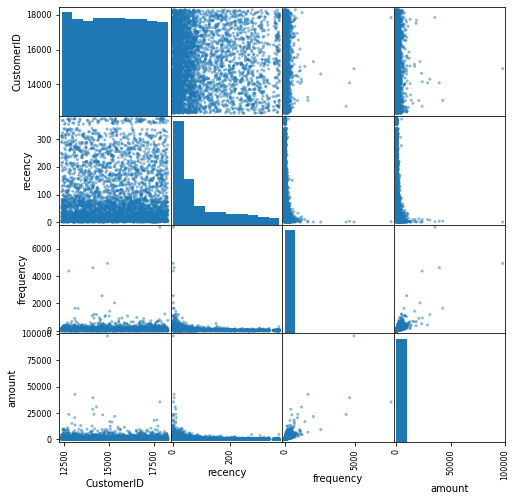

In [39]:
pd.plotting.scatter_matrix(customer_history_df, alpha=0.5, figsize=(8,8))

In [40]:
customer_history_df = customer_history_df[~(customer_history_df.amount>customer_history_df.amount.quantile(0.95))]

Normalizing all the values

In [41]:
scaleddata=dfv.copy()

In [42]:
scaleddata['StockCode'] = scaleddata['StockCode']  / scaleddata["StockCode"].abs().max()
scaleddata['UnitPrice'] = scaleddata['UnitPrice']  / scaleddata["UnitPrice"].abs().max()
scaleddata['Quantity'] = scaleddata['Quantity']  / scaleddata["Quantity"].abs().max()
#scaleddata['CustomerID'] = scaleddata['CustomerID']  / scaleddata["CustomerID"].abs().max()
scaleddata['amount'] = scaleddata['amount']  / scaleddata["amount"].abs().max()
scaleddata['InvoiceNo'] = scaleddata['InvoiceNo']  / scaleddata["InvoiceNo"].abs().max()

In [43]:
customer_history_df['recency'] = customer_history_df['recency']  / customer_history_df["recency"].abs().max()
customer_history_df['frequency'] = customer_history_df['frequency']  / customer_history_df["frequency"].abs().max()
customer_history_df['amount'] = customer_history_df['amount']  / customer_history_df["amount"].abs().max()
#customer_history_df['CustomerID'] = customer_history_df['CustomerID']  / customer_history_df["CustomerID"].abs().max()

C:\Users\gv7lo\AppData\Local\Temp/ipykernel_17060/3080904936.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_history_df['recency'] = customer_history_df['recency']  / customer_history_df["recency"].abs().max()
C:\Users\gv7lo\AppData\Local\Temp/ipykernel_17060/3080904936.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_history_df['frequency'] = customer_history_df['frequency']  / customer_history_df["frequency"].abs().max()
C:\Users\gv7lo\AppData\Local\Temp/ipykernel_17060/3080904936

In [44]:
customer_history_df

,CustomerID,recency,frequency,amount
0,12347.0,0.005348,0.178828,0.903350
1,12348.0,0.665775,0.006166,0.021767
2,12349.0,0.050802,0.067831,0.310610
3,12350.0,0.828877,0.016444,0.071043
4,12352.0,0.096257,0.072970,0.297408
...,...,...,...,...
4209,18280.0,0.743316,0.009250,0.038780
4210,18281.0,0.483957,0.005139,0.011323
4211,18282.0,0.021390,0.008222,0.027300
4212,18283.0,0.010695,0.774923,0.499278


In [45]:
quantiles = customer_history_df.quantile(q=[0.25, 0.5, 0.75])
quantiles.drop('CustomerID', axis=1, inplace=True)

In [46]:
quantiles.to_dict()

{'recency': {0.25: 0.053475935828877004,
  0.5: 0.1443850267379679,
  0.75: 0.40641711229946526},
 'frequency': {0.25: 0.015416238437821172,
  0.5: 0.03597122302158273,
  0.75: 0.08324768756423433},
 'amount': {0.25: 0.05481618942359205,
  0.5: 0.11700941615950039,
  0.75: 0.2677114050879115}}

In [47]:
def RScore(x,p,d):
  if x<=d[p][0.25]:
    return 4
  elif x<=d[p][0.50]:
    return 3
  elif x <= d[p][0.75]: 
    return 2
  else:
    return 1

def FMScore(x,p,d):
  if x <= d[p][0.25]:
    return 1
  elif x <= d[p][0.50]:
    return 2
  elif x <= d[p][0.75]: 
    return 3
  else:
    return 4

In [48]:
rfm_segmentation = customer_history_df
rfm_segmentation['R_Quartile'] = rfm_segmentation['recency'].apply(RScore, args=('recency',quantiles,))
rfm_segmentation['F_Quartile'] = rfm_segmentation['frequency'].apply(FMScore, args=('frequency',quantiles,))
rfm_segmentation['M_Quartile'] = rfm_segmentation['amount'].apply(FMScore, args=('amount',quantiles,))

C:\Users\gv7lo\AppData\Local\Temp/ipykernel_17060/482618764.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_segmentation['R_Quartile'] = rfm_segmentation['recency'].apply(RScore, args=('recency',quantiles,))
C:\Users\gv7lo\AppData\Local\Temp/ipykernel_17060/482618764.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_segmentation['F_Quartile'] = rfm_segmentation['frequency'].apply(FMScore, args=('frequency',quantiles,))
C:\Users\gv7lo\AppData\Local\Temp/ipykernel_17060/482618764.py:4: SettingWi

In [49]:
rfm_segmentation.head()

,CustomerID,recency,frequency,amount,R_Quartile,F_Quartile,M_Quartile
0,12347.0,0.005348,0.178828,0.903350,4,4,4
1,12348.0,0.665775,0.006166,0.021767,1,1,1
2,12349.0,0.050802,0.067831,0.310610,4,3,4
3,12350.0,0.828877,0.016444,0.071043,1,2,2
4,12352.0,0.096257,0.072970,0.297408,3,3,4


In [50]:
rfm_segmentation['RFMScore'] = rfm_segmentation.R_Quartile.map(str) \
                            + rfm_segmentation.F_Quartile.map(str) \
                            + rfm_segmentation.M_Quartile.map(str)
rfm_segmentation.head()

C:\Users\gv7lo\AppData\Local\Temp/ipykernel_17060/896421354.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_segmentation['RFMScore'] = rfm_segmentation.R_Quartile.map(str) \


,CustomerID,recency,frequency,amount,R_Quartile,F_Quartile,M_Quartile,RFMScore
0,12347.0,0.005348,0.178828,0.903350,4,4,4,444
1,12348.0,0.665775,0.006166,0.021767,1,1,1,111
2,12349.0,0.050802,0.067831,0.310610,4,3,4,434
3,12350.0,0.828877,0.016444,0.071043,1,2,2,122
4,12352.0,0.096257,0.072970,0.297408,3,3,4,334


In [51]:
rfm_segmentation[rfm_segmentation['RFMScore']=='444'].sort_values('amount', ascending=False).head(10)

,CustomerID,recency,frequency,amount,R_Quartile,F_Quartile,M_Quartile,RFMScore
3567,17364.0,0.002674,0.404933,1.000000,4,4,4,444
284,12700.0,0.021390,0.260021,0.989884,4,4,4,444
675,13267.0,0.008021,0.201439,0.989080,4,4,4,444
2425,15727.0,0.045455,0.288798,0.985297,4,4,4,444
1253,14085.0,0.005348,0.440904,0.978255,4,4,4,444
296,12714.0,0.024064,0.254882,0.973641,4,4,4,444
3125,16722.0,0.045455,0.209661,0.972632,4,4,4,444
3568,17365.0,0.034759,0.448099,0.971778,4,4,4,444
1257,14092.0,0.021390,0.216855,0.967005,4,4,4,444
2058,15218.0,0.029412,0.154162,0.961908,4,4,4,444


In [52]:
print("Best Customers: ",len(rfm_segmentation[rfm_segmentation['RFMScore']=='444']))
print('Loyal Customers: ',len(rfm_segmentation[rfm_segmentation['F_Quartile']==4]))
print("Big Spenders: ",len(rfm_segmentation[rfm_segmentation['M_Quartile']==4]))
print('Almost Lost: ', len(rfm_segmentation[rfm_segmentation['RFMScore']=='244']))
print('Lost Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='144']))
print('Lost Cheap Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='111']))


Best Customers:  356
Loyal Customers:  995
Big Spenders:  1001
Almost Lost:  120
Lost Customers:  24
Lost Cheap Customers:  358


#**`K Means`**

In [53]:
customer_history_df.drop(['R_Quartile','F_Quartile','M_Quartile','RFMScore'],axis=1,inplace=True)

C:\Users\gv7lo\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [54]:
customer_history_df

,CustomerID,recency,frequency,amount
0,12347.0,0.005348,0.178828,0.903350
1,12348.0,0.665775,0.006166,0.021767
2,12349.0,0.050802,0.067831,0.310610
3,12350.0,0.828877,0.016444,0.071043
4,12352.0,0.096257,0.072970,0.297408
...,...,...,...,...
4209,18280.0,0.743316,0.009250,0.038780
4210,18281.0,0.483957,0.005139,0.011323
4211,18282.0,0.021390,0.008222,0.027300
4212,18283.0,0.010695,0.774923,0.499278


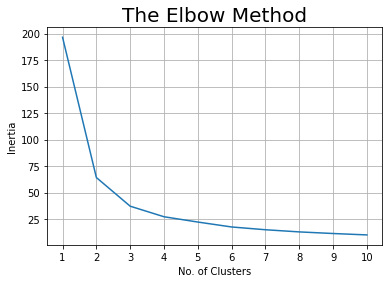

In [55]:
rf = customer_history_df.iloc[:, [1, 2]].values
ar = customer_history_df.iloc[:, [3, 1]].values
fa = customer_history_df.iloc[:, [2, 3]].values

wcss = []
for i in range(1, 11):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    km.fit(fa)
    wcss.append(km.inertia_)
    
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('Inertia')
plt.xticks(ticks=(1,2,3,4,5,6,7,8,9,10))
plt.grid()
plt.show()

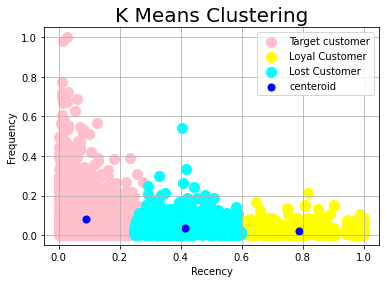

In [56]:
# model = KMeans(n_clusters=2, init="k-means++",random_state=101)
# model.fit(customer_history_df)
# clusters = model.fit_predict(customer_history_df)
km = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_means = km.fit_predict(rf)

plt.scatter(rf[y_means == 0, 0], rf[y_means == 0, 1], s = 100, c = 'pink', label = 'Target customer')
plt.scatter(rf[y_means == 1, 0], rf[y_means == 1, 1], s = 100, c = 'yellow', label = 'Loyal Customer')
plt.scatter(rf[y_means == 2, 0], rf[y_means == 2, 1], s = 100, c = 'cyan', label = 'Lost Customer')
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:, 1], s = 50, c = 'blue' , label = 'centeroid')
plt.style.use('seaborn-colorblind')
plt.title('K Means Clustering', fontsize = 20)
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()



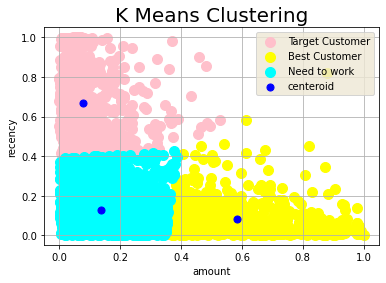

In [57]:
km = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_means = km.fit_predict(ar)

plt.scatter(ar[y_means == 0, 0], ar[y_means == 0, 1], s = 100, c = 'pink', label = 'Target Customer')
plt.scatter(ar[y_means == 1, 0], ar[y_means == 1, 1], s = 100, c = 'yellow', label = 'Best Customer')
plt.scatter(ar[y_means == 2, 0], ar[y_means == 2, 1], s = 100, c = 'cyan', label = 'Need to work')
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:, 1], s = 50, c = 'blue' , label = 'centeroid')
plt.style.use('Solarize_Light2')

plt.title('K Means Clustering', fontsize = 20)
plt.xlabel('amount')
plt.ylabel('recency')
plt.legend()
plt.grid()
plt.show()

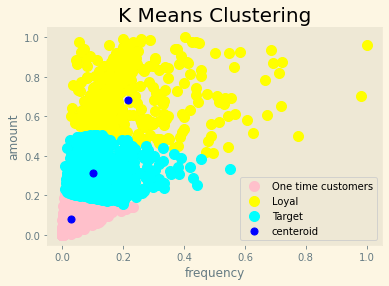

In [58]:
km = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 50)
y_means = km.fit_predict(fa)

plt.scatter(fa[y_means == 0, 0], fa[y_means == 0, 1], s = 100, c = 'pink', label = 'One time customers')
plt.scatter(fa[y_means == 1, 0], fa[y_means == 1, 1], s = 100, c = 'yellow', label = 'Loyal')
plt.scatter(fa[y_means == 2, 0], fa[y_means == 2, 1], s = 100, c = 'cyan', label = 'Target')
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:, 1], s = 50, c = 'blue' , label = 'centeroid')

plt.style.use('seaborn-colorblind')
plt.title('K Means Clustering', fontsize = 20)
plt.xlabel('frequency')
plt.ylabel('amount')
plt.legend()
plt.grid()
plt.show()

#**Apriori Algorithm**

In [59]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

In [60]:
dfv

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount,year,month,hour,weekday,days_since_last_purchase
0,536365,0,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010,12,8,Wednesday,374.0
1,536365,406,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,8,Wednesday,374.0
2,536365,457,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010,12,8,Wednesday,374.0
3,536365,281,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,8,Wednesday,374.0
4,536365,275,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,8,Wednesday,374.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,1066,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20,2011,12,12,Friday,1.0
541905,581587,408,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60,2011,12,12,Friday,1.0
541906,581587,367,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011,12,12,Friday,1.0
541907,581587,864,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011,12,12,Friday,1.0


here we are making the dataset suitable for apriori algorithm

In [61]:
basket = (dfv.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo'))
basket

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,TRELLIS COAT RACK,10 COLOUR SPACEBOY PEN,...,ZINC PLANT POT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581582,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,12.0,0.0,0.0,24.0,0.0,0.0


using the encode function to convert all int values greater than 0 to 1

In [62]:
basket_sets = basket.applymap(encode_units)

In [63]:
basket_sets

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,TRELLIS COAT RACK,10 COLOUR SPACEBOY PEN,...,ZINC PLANT POT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581582,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581583,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581585,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


getting the frequent itemsets

In [64]:
frequent_itemsets = apriori(basket_sets, min_support=0.01, use_colnames=True)

MemoryError: Unable to allocate 50.0 GiB for an array with shape (195625, 2, 17151) and data type int64

applying association rules 

In [ ]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0.6)
rules.sort_values('consequent support', ascending=False).reset_index()

when we used whole dataset, ignoring the countries, the support values are quite low, lets check if countrywise the support values vary by a lot

In [ ]:
top_5=dfv.groupby('Country')['Quantity'].sum()

In [ ]:
top_5.sort_values(ascending=False).head()

a function to create encoded dataset suitable to apriori

In [ ]:
def create_basket(country_filter):
    basket = (dfv[dfv['Country'] == country_filter].groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo'))
    basket_sets = basket.applymap(encode_units)
    return basket_sets

In [ ]:
france=create_basket('France')
f_frequent_itemsets = apriori(france, min_support=0.6, use_colnames=True)
f_rules=association_rules(frequent_itemsets, metric='lift', min_threshold=0.60).sort_values('consequent support', ascending=False)
f_rules

In [ ]:
germany=create_basket('Germany')
g_frequent_itemsets = apriori(germany, min_support=0.6, use_colnames=True)
g_rules=association_rules(frequent_itemsets, metric='lift', min_threshold=0.60).sort_values('consequent support', ascending=False)
g_rules

In [ ]:
uk=create_basket('United Kingdom ')
uk_frequent_itemsets = apriori(uk, min_support=0.6, use_colnames=True)
uk_rules=association_rules(frequent_itemsets, metric='lift', min_threshold=0.60).sort_values('consequent support', ascending=False)
uk_rules

In [ ]:
s=create_basket('Switzerland')
s_frequent_itemsets = apriori(s, min_support=0.6, use_colnames=True)
s_rules=association_rules(frequent_itemsets, metric='lift', min_threshold=0.60).sort_values('consequent support', ascending=False)
s_rules

In [ ]:
eire=create_basket('EIRE')
eire_frequent_itemsets = apriori(eire, min_support=0.6, use_colnames=True)
eire_rules=association_rules(frequent_itemsets, metric='lift', min_threshold=0.60).sort_values('consequent support', ascending=False)
eire_rules